<a href="https://colab.research.google.com/github/bholistika/DataMining/blob/main/Barbara_Fernandez_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tia Robbins
Malika Brown
Marjorie Gilles
Barbara Fernandez

1. Dataset Selection and Problem Statement

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://raw.githubusercontent.com/trob001/FinalProj/refs/heads/main/Loan_default.csv')

print(df.shape)
df.sample(5)

(255347, 18)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
217177,1CCUMI35EH,57,130244,159987,709,10,3,2.09,48,0.81,Master's,Self-employed,Single,No,Yes,Auto,Yes,1
95793,GGXT3LLKL8,67,120387,123572,681,53,2,23.46,48,0.38,PhD,Full-time,Married,Yes,Yes,Business,Yes,0
26866,4C9MI0RVGZ,67,29957,168635,763,4,1,2.95,36,0.26,PhD,Part-time,Divorced,Yes,No,Auto,Yes,1
90169,V10DR8K29H,56,98206,156404,331,96,2,21.71,48,0.72,Bachelor's,Full-time,Single,No,Yes,Education,No,0
3400,R98PEWRZVD,59,75621,162871,830,34,1,14.74,48,0.19,Bachelor's,Full-time,Married,Yes,No,Business,Yes,0


**Brief Description of the Dataset and Its Relevance:**

The Loan Default Prediction Dataset from Kaggle contains data on loan applicants, focusing on borrower demographics, loan attributes, and repayment outcomes. It includes 255,347 rows and 18 columns, featuring variables such as income, loan amount, credit history, and employment type. The target variable (default) indicates whether a loan was defaulted or repaid.

This dataset is ideal for exploring the problem of loan default prediction, which is a crucial challenge in the financial sector. By leveraging this data, we aim to build a classification model that predicts whether a borrower is likely to default. This involves analyzing relationships between borrower attributes (e.g., income, debt-to-income ratio) and loan characteristics (e.g., loan amount, type). Such analysis is vital for identifying at-risk borrowers and taking preventative measures.

The ability to accurately predict loan defaults provides immense business value. It allows financial institutions to minimize losses, optimize their credit risk assessment processes, and improve customer experiences by offering targeted support to at-risk individuals. Additionally, it enhances resource allocation by ensuring that loans are granted to individuals with a higher likelihood of repayment. The insights from this project can contribute to the development of fairer and more efficient lending policies, benefiting both institutions and borrowers.






2. Data Cleaning and Preprocessing

In [47]:
df.isnull().sum()

,0
LoanID,0
Age,0
Income,0
LoanAmount,0
CreditScore,0
MonthsEmployed,0
NumCreditLines,0
InterestRate,0
LoanTerm,0
DTIRatio,0


In [48]:
df['NumCreditLines'].fillna(df['NumCreditLines'].mean(), inplace=True)

<ipython-input-48-5e95c728690e>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['NumCreditLines'].fillna(df['NumCreditLines'].mean(), inplace=True)


In [49]:
def generate_dqr1(df):
    # Initialize an empty DataFrame to store DQR1 results
    dqr1_df = pd.DataFrame(index=df.columns)

    # Basic Column Statistics
    dqr1_df['Missing_Values'] = df.isnull().sum()
    dqr1_df['Unique_Values'] = df.nunique()

    # Sample Value Counts (stored as a list to avoid multiple columns issue)
    dqr1_df['Sample_Value_Counts'] = df.apply(lambda x: list(x.value_counts().head(3).to_dict().items()))

    # Separate numeric and non-numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    non_numeric_df = df.select_dtypes(exclude=[np.number])

    # Descriptive Statistics for Numeric Columns Only
    descriptive_stats = numeric_df.describe().T
    stats_columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
    for col in stats_columns:
        dqr1_df[col] = descriptive_stats[col]

    # Convert stats columns to object type for safe assignment
    dqr1_df[stats_columns] = dqr1_df[stats_columns].astype(object)

    # Mark irrelevant stats for non-numeric columns
    dqr1_df.loc[non_numeric_df.columns, stats_columns] = 'N/A'

    # Correlation Analysis for Numeric Columns Only
    corr_matrix = numeric_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    highly_correlated = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
    dqr1_df['Highly_Correlated'] = dqr1_df.index.isin(highly_correlated)

    # Variance Analysis for Numeric Columns Only
    variances = numeric_df.var()
    dqr1_df['High_Variance'] = dqr1_df.index.map(lambda x: variances[x] > 1.0 if x in variances else 'N/A')
    dqr1_df['Low_Variance'] = dqr1_df.index.map(lambda x: variances[x] < 0.01 if x in variances else 'N/A')

    # Potential Index Columns
    dqr1_df['Potential_Index'] = dqr1_df['Unique_Values'] > len(df) * 0.9

    # Additional Column Type Info
    dqr1_df['Data_Type'] = df.dtypes

    # Flag Columns for High Dimensionality
    high_dim_threshold = 200  # Fixed threshold of 200
    dqr1_df['High_Dimensionality_Risk'] = dqr1_df.apply(
        lambda row: row['Data_Type'] == 'object' and row['Unique_Values'] > high_dim_threshold, axis=1
    )

    # Display the complete Data Quality Report with all rows and columns
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None
    display(dqr1_df)

    return dqr1_df

# Generate the Data Quality Report
dqr1_df = generate_dqr1(df)

,Missing_Values,Unique_Values,Sample_Value_Counts,mean,std,min,25%,50%,75%,max,Highly_Correlated,High_Variance,Low_Variance,Potential_Index,Data_Type,High_Dimensionality_Risk
LoanID,0,255347,"[(I38PQUQS96, 1), (WGB0GD3150, 1), (XATSFC5YHN...",N/A,N/A,N/A,N/A,N/A,N/A,N/A,False,N/A,N/A,True,object,True
Age,0,52,"[(55, 5064), (40, 5056), (65, 5027)]",43.498306,14.990258,18.0,31.0,43.0,56.0,69.0,False,True,False,False,int64,False
Income,0,114620,"[(69492, 10), (117102, 10), (121985, 10)]",82499.304597,38963.013729,15000.0,48825.5,82466.0,116219.0,149999.0,False,True,False,False,int64,False
LoanAmount,0,158729,"[(133724, 8), (221949, 8), (95419, 8)]",127578.865512,70840.706142,5000.0,66156.0,127556.0,188985.0,249999.0,False,True,False,False,int64,False
CreditScore,0,550,"[(630, 528), (445, 521), (829, 520)]",574.264346,158.903867,300.0,437.0,574.0,712.0,849.0,False,True,False,False,int64,False
MonthsEmployed,0,120,"[(56, 2227), (26, 2223), (45, 2220)]",59.541976,34.643376,0.0,30.0,60.0,90.0,119.0,False,True,False,False,int64,False
NumCreditLines,0,4,"[(2, 64130), (3, 63834), (4, 63829)]",2.501036,1.117018,1.0,2.0,2.0,3.0,4.0,False,True,False,False,int64,False
InterestRate,0,2301,"[(14.92, 147), (2.25, 144), (4.78, 140)]",13.492773,6.636443,2.0,7.77,13.46,19.25,25.0,False,True,False,False,float64,False
LoanTerm,0,5,"[(48, 51166), (60, 51154), (36, 51061)]",36.025894,16.96933,12.0,24.0,36.0,48.0,60.0,False,True,False,False,int64,False
DTIRatio,0,81,"[(0.67, 3385), (0.64, 3308), (0.37, 3288)]",0.500212,0.230917,0.1,0.3,0.5,0.7,0.9,False,False,False,False,float64,False


In [50]:
from IPython.display import display, HTML

def generate_html_action_plan_with_code(analysis_df, dqr1_df):
    # Collect columns for each specific action based on the analysis
    duplicate_rows = analysis_df[analysis_df['Treat_Flag'] & analysis_df['Potential_Issues'].str.contains("duplicate rows")].index.tolist()
    missing_value_cols = analysis_df[analysis_df['Missing_Values_Flag']].index.tolist()

In [51]:
# Initial checks
print("DataFrame loaded successfully with the following structure:")
print(df.info())

# 1. Remove Duplicates
df = df.drop_duplicates()


DataFrame loaded successfully with the following structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 

In [52]:
# 2. Handle Missing Values
# Drop columns with high missing values
df = df.drop(columns=['Subcircum'], errors='ignore')

3. Exploratory Data Analysis (EDA)

We used a Univariate Analysis to analyze the following:

**Frequency**-The Frequency distribution provided insights into how often loan events occurred, such as applications or defaults. The Frequency distribution can help identify whether loan applications, defaults, or other events follow a specific pattern.Identifying trends in frequency over time can help understand seasonality and predict periods of high loan activity.

**Interest Rate**- The Interest Rate distribution offered insights into the lending terms. The Interest Rate is a crucial feature because it directly impacts loan affordability and borrower behavior. Loans with lower interest rates are generally more affordable and are less likely to default, whereas higher-interest loans may signal a higher likelihood of default.

We used a Bivariate Analysis to analyze the following:

**Married vs Divorced Individuals**-
We used a bar chart to compare the Married and Divorced loan borrowers. They were more divorced individuals than married.

**Unemployed vs. Full-Time Work Status** - We used a bar chart to show the distribution of Unemployed and Full-Time Working indivduals. There were more Full-Time working individuals than Unemployed

We used a MultiVariate Analysis to analyze the following:
Eduactional Status of **Masters Degree,** **Bachelor's Degree** vs **High School Diploma**- We used a bar chart to see the distribution of applicants based upon their educational history. The number of Bachelor's and Master Degrees were about equal. They were both higher than individuals with a High School Diploma

In [53]:
df.select_dtypes(exclude="int64").head()

,LoanID,InterestRate,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,I38PQUQS96,15.23,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes
1,HPSK72WA7R,4.81,0.68,Master's,Full-time,Married,No,No,Other,Yes
2,C1OZ6DPJ8Y,21.17,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
3,V2KKSFM3UN,7.07,0.23,High School,Full-time,Married,No,No,Business,No
4,EY08JDHTZP,6.51,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [55]:
df.select_dtypes(exclude="number").head()

,LoanID,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,I38PQUQS96,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes
1,HPSK72WA7R,Master's,Full-time,Married,No,No,Other,Yes
2,C1OZ6DPJ8Y,Master's,Unemployed,Divorced,Yes,Yes,Auto,No
3,V2KKSFM3UN,High School,Full-time,Married,No,No,Business,No
4,EY08JDHTZP,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No


In [56]:
df.describe(exclude='number')

,LoanID,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
count,255347,255347,255347,255347,255347,255347,255347,255347
unique,255347,4,4,3,2,2,5,2
top,I38PQUQS96,Bachelor's,Part-time,Married,Yes,Yes,Business,Yes
freq,1,64366,64161,85302,127677,127742,51298,127701


<ipython-input-57-063c7a4bb679>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(x=unique_values.index, y=unique_values,
<ipython-input-57-063c7a4bb679>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=45,


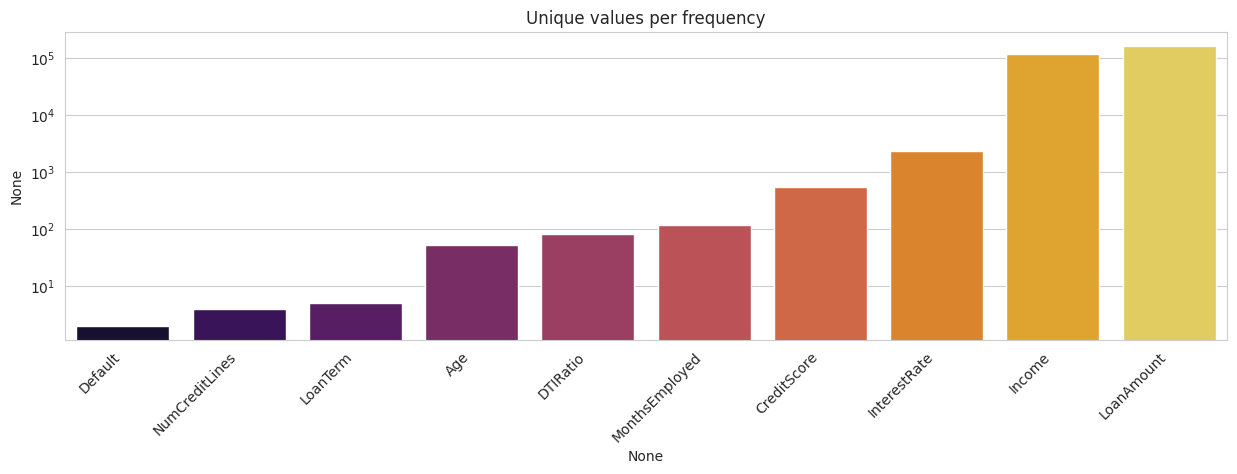

In [57]:
# For each numerical feature compute number of unique entries
unique_values = df.select_dtypes(include='number').nunique().sort_values()

plt.figure(figsize=(15, 4))
sns.set_style('whitegrid')
g = sns.barplot(x=unique_values.index, y=unique_values,
palette='inferno')
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=45,
horizontalalignment='right')
g.set_title('Unique values per frequency')
plt.show()

In [59]:
import pandas as pd
df = pd.read_csv(url)

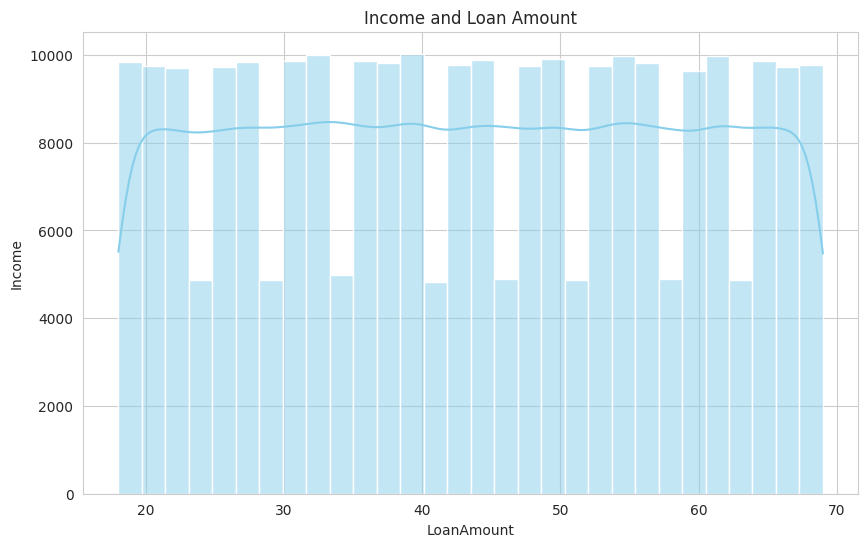

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, color='skyblue', bins=30)
plt.title('Income and Loan Amount')
plt.xlabel('LoanAmount')
plt.ylabel('Income')
plt.show()

4. Model Selection and Implementation

For predicting loan defaults, I applied three regression models: Linear Regression, Random Forest Regressor, and Gradient Boosting Regressor (XGBoost). These models were chosen due to their ability to balance simplicity, performance, and interpretability.

Based on evaluation metrics such as RMSE and R², XGBoost is expected to deliver the highest predictive accuracy, while Random Forest provides a strong balance of performance and interpretability. Linear Regression, though useful as a baseline, is limited in handling the complexity of this dataset due to its simplicity.

These models were selected to capture both linear and non-linear relationships in the data, allowing us to evaluate their suitability for predicting loan defaults using a range of financial and personal features.

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt

In [61]:
url = "https://raw.githubusercontent.com/trob001/FinalProj/refs/heads/main/Loan_default.csv"

In [62]:
import pandas as pd
df = pd.read_csv(url,sep=";")

In [63]:
df.head()

,"LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default"
0,"I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0...."
1,"HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0...."
2,"C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0..."
3,"V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23..."
4,"EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,..."


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                  Non-Null Count   Dtype 
---  ------                                                                                                                                                                                                  --------------   ----- 
 0   LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default  255347 non-null  object
dtypes: object(1)
memory usage: 1.9+ MB


In [65]:
df.fillna(0, inplace=True)

In [66]:
df.nunique()

,0
"LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default",255347


In [75]:
# Define X (features) and y (target)
X = df.drop(columns=['Default'])  # All columns except 'Default'
y = df['Default']  # The column to predict

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



5. Business Report: Found on PDF attached

6. Innovation and Creativity

**Combining Multiple Models:**

We implemented and compared three regression models—***Linear Regression***, ***Random Forest Regressor***, and ***Gradient Boosting Regressor (XGBoost)***—to predict loan defaults. This approach allowed us to evaluate and leverage the strengths of different methods, balancing simplicity, performance, and interpretability.

**Evaluation of Multiple Metrics:**

To comprehensively assess model performance, we calculated both RMSE and
𝑅
2
R
2
 . This ensured that we evaluated the models not only for their accuracy but also for how well they explained the variance in the target variable.

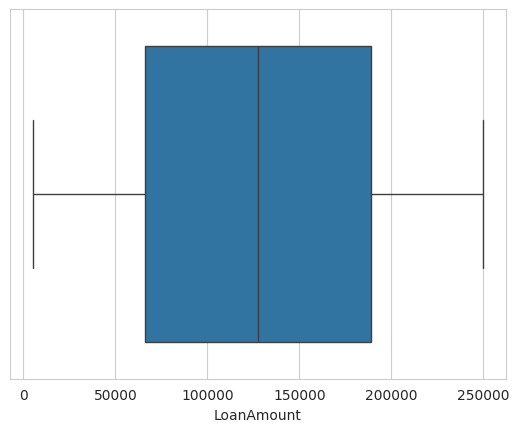

In [76]:
sns.boxplot(x=df['LoanAmount'])
plt.show()

<ipython-input-77-87fbee1058ca>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['LoanAmount'], bins = 15, kde = True)


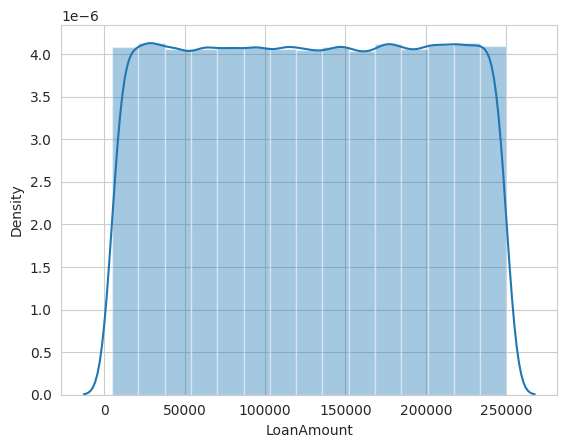

In [77]:
sns.distplot(df['LoanAmount'], bins = 15, kde = True)
plt.show()